# Full Workbench disease network
- Pull studies from API with REFMET
    - Combine assays?
- Threshold on number of REFMET compounds?
- Build bipartite graph with only overlapping compounds

In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
# get disease associations
disease_url = 'https://www.metabolomicsworkbench.org/rest/study/study_id/ST/disease'
disease_assoc = requests.get(disease_url)
disease_json = disease_assoc.json()

In [16]:
disease_assoc_df = pd.DataFrame.from_dict(disease_json, orient='index')

In [19]:
disease_assoc_df['Disease'].value_counts()

Disease
Cancer                     402
Diabetes                   103
Obesity                     63
Malaria                     45
Environmental exposure      43
                          ... 
Psoriasis                    1
Valley fever                 1
Urinary tract infection      1
Heat stroke                  1
Maternal Hypoxemia           1
Name: count, Length: 201, dtype: int64

In [21]:
disease_assoc_df['Disease'].value_counts().head(10).reset_index()

,Disease,count
0,Cancer,402
1,Diabetes,103
2,Obesity,63
3,Malaria,45
4,Environmental exposure,43
5,Eye disease,37
6,Fatty liver disease,37
7,Heart disease,33
8,Tuberculosis,28
9,Spinal cord injury,26


C:\Users\cw2019\AppData\Local\Temp\ipykernel_32988\3327851847.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


<Axes: xlabel='count', ylabel='Disease'>

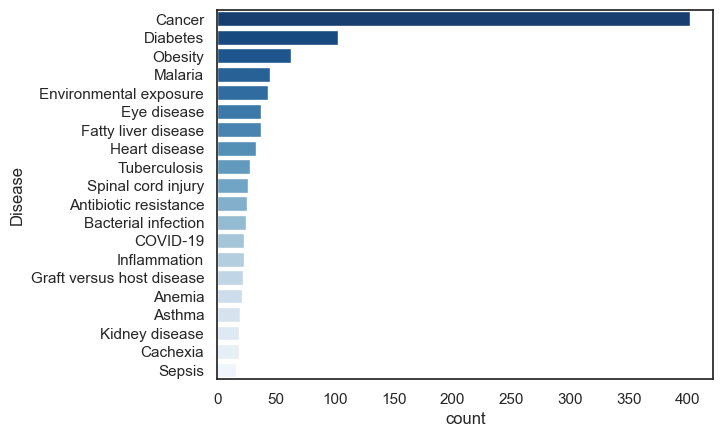

In [26]:
# plot top 10 diseases
sns.set(
    style='white'
)
sns.barplot(
    data=disease_assoc_df['Disease'].value_counts().head(20).reset_index(),
    x='count',
    y='Disease',
    palette='Blues_r'
)

## Download all study data

In [27]:
named_met_url = 'https://www.metabolomicsworkbench.org/rest/study/study_id/ST/named_metabolites/'
named_met_dat = requests.get(named_met_url)
named_met_json = named_met_dat.json()
named_met_df = pd.DataFrame.from_dict(named_met_json, orient='index')

In [ ]:

# Get assays for each study
for s in studies:
    
    base_url = 'https://www.metabolomicsworkbench.org/rest/study/study_id/repl/analysis'
    resp = requests.get(base_url.replace('repl', s)).json()
    print(resp)
    if list(resp.keys())[0] != '1':
        resp_series = pd.Series(resp)
        print(resp_series['analysis_id'])
        studies_assays[s] = [resp_series['analysis_id']]
    else:
        resp_df = pd.DataFrame.from_dict(resp).T
        print(resp_df['analysis_id'].tolist())
        studies_assays[s] = resp_df['analysis_id'].tolist()

In [ ]:
# download all assays per study
for study in studies:
    print(study)
    base_url = 'https://www.metabolomicsworkbench.org/rest/study/analysis_id/'
    #check if directory exists
    if not os.path.isdir('Studies/'+study):
        os.mkdir('Studies/'+study)

        for assay in studies_assays[study]:
            url = base_url + assay + '/datatable/file'
            print(url)
            pd.read_csv(url, sep='\t').to_csv('Studies/'+study+'/'+f'{assay}.csv', index=False)
    else:
        pass